Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tensorflow Similarity Sampler I/O Cookbook

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/similarity/blob/master/examples/sampler_io_cookbook.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/similarity/blob/master/examples/sampler_io_cookbook.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Tensorflow Similarity's Samplers ensure that each batch contains a target number of examples per class per batch. This ensures that the loss functions are able to construct tuples of anchor, positive, and negatives within each batch of examples.

![contrastive_batch.png](https://raw.githubusercontent.com/tensorflow/similarity/master/assets/images/contrastive_batch.png)

In this notebook you will learn how to use the:

* `MultiShotMemorySampler()` for fitting to a sequence of data, such as a dataset.
* `SingleShotMemorySampler()` to treat each example as a seperate class and generate augmented versions within each batch.
* `TFDatasetMultiShotMemorySampler()` to directly integrate with the Tensorflow dataset catalog. 
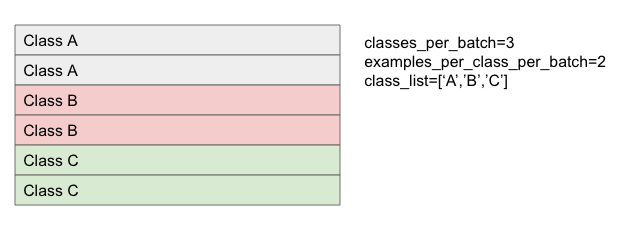

In [2]:
%load_ext autoreload
%autoreload 2

## Imports

In [3]:
import random
from typing import Tuple

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

In [5]:
# Samplers
from tensorflow_similarity.samplers import MultiShotMemorySampler
from tensorflow_similarity.samplers import SingleShotMemorySampler
from tensorflow_similarity.samplers import TFDatasetMultiShotMemorySampler
from tensorflow_similarity.samplers import TFRecordDatasetSampler
from tensorflow_similarity.samplers import select_examples  # select n example per class

In [6]:
from tensorflow_similarity.types import FloatTensor, IntTensor
from tensorflow_similarity.utils import tf_cap_memory

In [7]:
tfsim.utils.tf_cap_memory() # Avoid GPU memory blow up

Physical devices cannot be modified after being initialized


<hr>

# MultiShotMemorySampler: Load Random Numpy Arrays
The following cell loads random numpy data using TensorFlow similarity`MultiShotMemorySampler()`.

Using a sampler is required to ensure that each batch contains at least N samples for each class included in a batch. 

This batch strucutre is required for the contrastive loss to properly compute positive pairwise distances.

In [8]:
num_ms_examples = 100_000 #@param {type:"slider", min:1000, max:1000000}
num_ms_features = 784 #@param {type:"slider", min:10, max:1000}
num_ms_classes = 10 #@param {type:"slider", min:2, max:1000}

# We use random floats here to represent a dense feature vector
X_ms = np.random.rand(num_ms_examples, num_ms_features)
# We use random ints to represent N different classes
y_ms = np.random.randint(low=0, high=10, size=num_ms_examples)

In [9]:
num_known_ms_classes = 5 #@param {type:"slider", min:2, max:1000}
ms_classes_per_batch = num_known_ms_classes
ms_examples_per_class_per_batch = 2 #@param {type:"integer"}
ms_class_list = random.sample(range(num_ms_classes), k=num_known_ms_classes)

ms_sampler = MultiShotMemorySampler(
    X_ms, 
    y_ms, 
    classes_per_batch=ms_classes_per_batch,
    examples_per_class_per_batch=ms_examples_per_class_per_batch,
    class_list=ms_class_list
)


Batch size is 10 -> 5 class * 2 examples * (1 + 0 augmentations)


filtering examples:   0%|          | 0/100000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/5 [00:00<?, ?it/s]

gather examples:   0%|          | 0/49899 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/49899 [00:00<?, ?it/s]

## Generating Batches
The Tensorflow Similarity memory samplers are a subclass of [tf.keras.utils.Sequence](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence), overriding the `__getitem__` and `__len__` methods. 

Additionally, Tensorflow Similarity provides a `generate_batch()` method that takes a batch ID and yields a single batch. 

We verify that the batch batch only conatins the classes defined in `CLASS_LIST` and that each class has `ms_classes_per_batch` * `ms_examples_per_class_per_batch` examples. 

In [10]:
X_ms_batch, y_ms_batch = ms_sampler.generate_batch(100)
print("#"*10+" X "+"#"*10)
print(X_ms_batch)
print("\n"+"#"*10+" y "+"#"*10)
print(y_ms_batch)

# Check that the batch size is equal to the target number of classes * target number of examples per class.
assert tf.shape(X_ms_batch)[0] == (ms_classes_per_batch * ms_examples_per_class_per_batch)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_ms_batch)[1] == (num_ms_features)
# Check that classes in the batch are from the allowed set in CLASS_LIST
assert set(tf.unique(y_ms_batch)[0].numpy()) - set(ms_class_list) == set()
# Check that we only have NUM_CLASSES_PER_BATCH
assert len(tf.unique(y_ms_batch)[0]) == ms_classes_per_batch

########## X ##########
tf.Tensor(
[[0.59346679 0.9217064  0.44887729 ... 0.30106703 0.87127325 0.71388802]
 [0.46486462 0.45527414 0.77700672 ... 0.2077887  0.51117709 0.52399318]
 [0.78014978 0.96024415 0.17272364 ... 0.47270043 0.37236176 0.47555172]
 ...
 [0.55723576 0.98819534 0.67612029 ... 0.11103861 0.77478356 0.351957  ]
 [0.19114347 0.02567722 0.21945899 ... 0.96899724 0.33233155 0.09366371]
 [0.60851141 0.04553891 0.31261641 ... 0.11535945 0.1584726  0.05854537]], shape=(10, 784), dtype=float64)

########## y ##########
tf.Tensor([6 3 1 0 0 3 1 5 5 6], shape=(10,), dtype=int64)


## Sampler Sizes

`MultiShotMemorySampler()` provides various attributes for accessing info about the data:
* `__len__` provides the number of steps per epoch. 
* `num_examples` provides the total number of examples within the sampler.
* `example_shape` provides the shape of the examples.

The `num_examples` attribute represents the subset of X and y where y is in the `class_list` with each class limited to `num_examples_per_class`.

In [11]:
print(f'The sampler contains {len(ms_sampler)} steps per epoch.')
print(f'The sampler is using {ms_sampler.num_examples} examples out of the original {num_ms_examples}.')
print(f'Each examples has the following shape: {ms_sampler.example_shape}.')

The sampler contains 1000 steps per epoch.
The sampler is using 49899 examples out of the original 100000.
Each examples has the following shape: (784,).


## Accessing the Examples

Additionaly, the `MultiShotMemorySampler()` provides `get_slice()` for manually accessing examples within the Sampler.

**NOTE**: the examples are shuffled when creating the Sampler but will yield the same examples for each call to get_slice(begin, size).

In [12]:
# Get 10 examples starting at example 200.
X_ms_slice, y_ms_slice = ms_sampler.get_slice(begin=200, size=10)
print("#"*10+" X "+"#"*10)
print(X_ms_slice)
print("\n"+"#"*10+" y "+"#"*10)
print(y_ms_slice)

# Check that the batch size is equal to our get_slice size.
assert tf.shape(X_ms_slice)[0] == 10
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_ms_slice)[1] == (num_ms_features)
# Check that classes in the batch are from the allowed set in CLASS_LIST
assert set(tf.unique(y_ms_slice)[0].numpy()) - set(ms_class_list) == set()

########## X ##########
tf.Tensor(
[[0.11196142 0.13140621 0.33259832 ... 0.30568602 0.38773544 0.72168659]
 [0.54413131 0.55648372 0.18795954 ... 0.746883   0.76629221 0.33095865]
 [0.04460672 0.47076817 0.07663685 ... 0.21581133 0.37906724 0.66849205]
 ...
 [0.16650761 0.46147233 0.0696041  ... 0.07427268 0.84528562 0.04911605]
 [0.22770957 0.97824062 0.73667728 ... 0.80617242 0.68940879 0.95417338]
 [0.11890323 0.53401373 0.14999675 ... 0.67075828 0.84024539 0.55622732]], shape=(10, 784), dtype=float64)

########## y ##########
tf.Tensor([3 0 0 3 1 3 1 5 0 5], shape=(10,), dtype=int64)


<hr>

# SingleShotMemorySampler: Augmented MNIST Examples

The following cell loads and augments MNIST examples using the `SingleShotMemorySampler()`.

The Sampler treats each example as it's own class and adds augmented versions of each image to the batch.

This means the final batch size is the number of `examples per batch * (1 + the number of augmentations)`.

In [13]:
(aug_x, _), _ = tf.keras.datasets.mnist.load_data()
# Normalize the image data.
aug_x = tf.cast(aug_x / 255.0, dtype='float32')

In [60]:
aug_num_examples_per_batch = 18  #@param {type:"slider", min:18, max:512}
aug_num_augmentations_per_example = 1 #@param {type:"slider", min:1, max:3}

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.12),
    layers.experimental.preprocessing.RandomZoom(0.25),
])


def augmenter(
    x: FloatTensor, 
    y: IntTensor, 
    examples_per_class: int, 
    is_warmup: bool,
    stddev=0.025
) -> Tuple[FloatTensor, IntTensor]:
    """Image augmentation function.
    
    Args:
        X: FloatTensor representing the example features.
        y: IntTensor representing the class id. In this case 
           the example index will be used as the class id.
        examples_per_class: The number of examples per class. 
           Not used here.
        is_warmup: If True, the training is still in a warm 
           up state. Not used here.
        stddev: Sets the amount of gaussian noise added to 
           the image.
    """
    _ = examples_per_class
    _ = is_warmup
    
    aug = tf.squeeze(data_augmentation(tf.expand_dims(x,-1)))
    aug = aug + tf.random.normal(tf.shape(aug), stddev=stddev)
    x = tf.concat((x, aug), axis=0)
    y = tf.concat((y,y), axis=0)
    idxs = tf.range(start=0, limit=tf.shape(x)[0])
    idxs = tf.random.shuffle(idxs)
    x = tf.gather(x, idxs)
    y = tf.gather(y, idxs)
    return x, y
    

aug_sampler = SingleShotMemorySampler(
    aug_x,
    augmenter=augmenter,
    examples_per_batch=aug_num_examples_per_batch,
    num_augmentations_per_example=aug_num_augmentations_per_example,
)


Batch size is 36 -> 18 class * 1 examples * (1 + 1 augmentations)


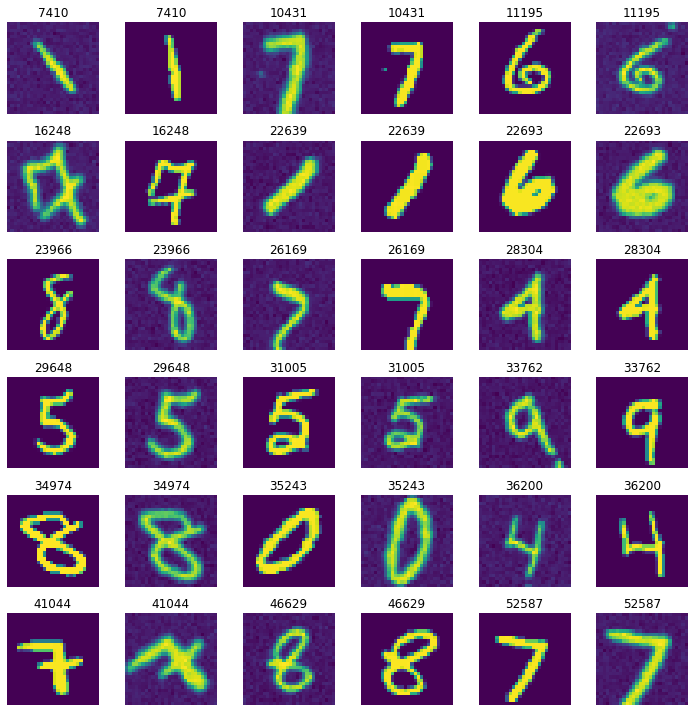

In [61]:
# Plot the first 36 examples
num_imgs = 36
num_row = num_col = 6
aug_batch_x, aug_batch_y = aug_sampler[0]
# Sort the class ids so we can see the original 
# and augmented versions as pairs.
sorted_idx = np.argsort(aug_batch_y)
plt.figure(figsize=(10, 10))
for i in range(num_imgs):
    idx = sorted_idx[i]
    ax = plt.subplot(num_row, num_col, i + 1)
    plt.imshow(aug_batch_x[idx])
    plt.title(int(aug_batch_y[idx]))
    plt.axis("off")

plt.tight_layout()

## Sampler Sizes

`SingleShotMemorySampler()` provides various attributes for accessing info about the data:
* `__len__` provides the number of steps per epoch. 
* `num_examples` provides the number of examples within the sampler.
* `example_shape` provides the shape of the examples.

The `num_examples` attribute represents the unaugmented examples within the sampler.

In [16]:
print(f'The sampler contains {len(aug_sampler)} steps per epoch.')
print(f'The sampler is using {aug_sampler.num_examples} examples out of the original {len(aug_x)}.')
print(f'Each examples has the following shape: {aug_sampler.example_shape}.')

The sampler contains 1000 steps per epoch.
The sampler is using 60000 examples out of the original 60000.
Each examples has the following shape: (28, 28).


## Accessing the Examples

Additionaly, the `SingleShotMemorySampler()` provides `get_slice()` for manually accessing examples within the Sampler.

The method returns slice size plus the augmented examples returned by the augmenter function.

In [17]:
# Get 10 examples starting at example 200.
X_aug_slice, y_aug_slice = aug_sampler.get_slice(begin=200, size=10)
print("#"*10+" X "+"#"*10)
print(tf.reshape(X_aug_slice, (10,-1)))
print("\n"+"#"*10+" y "+"#"*10)
print(y_aug_slice)

# Check that the batch size is double our get_slice size (original examples + augmented examples).
assert tf.shape(X_aug_slice)[0] == 10+10
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_aug_slice)[1] == (28)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_aug_slice)[2] == (28)

########## X ##########
tf.Tensor(
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.00035038  0.01473183 -0.04127895 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.013729   -0.00865667
   0.01033886]
 ...
 [ 0.00669398  0.0194897   0.01335412 ...  0.          0.
   0.        ]
 [ 0.01747736 -0.01761932  0.00931891 ...  0.          0.
   0.        ]
 [ 0.03462283  0.0273765   0.0225324  ...  0.0086752   0.00412598
   0.03862322]], shape=(10, 1568), dtype=float32)

########## y ##########
tf.Tensor(
[203 209 207 200 206 205 208 206 204 207 208 204 201 202 209 205 200 201
 203 202], shape=(20,), dtype=int32)


<hr>

# TFDatasetMultiShotMemorySampler: Load data from TF Dataset
The following cell loads data directly from the TensorFlow catalog using TensorFlow similarity
`TFDatasetMultiShotMemorySampler()`. 

Using a sampler is required to ensure that each batch contains at least N samples of each class incuded in a batch. Otherwise the contrastive loss does not work properly as it can't compute positive distances.

In [26]:
IMG_SIZE = 300 #@param {type:"integer"}

# preprocessing function that resizes images to ensure all images are the same shape
def resize(img, label):
    with tf.device("/cpu:0"):
        img = tf.cast(img, dtype="int32")
        img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
        return img, label   

In [27]:
training_classes = 16 #@param {type:"slider", min:1, max:37}
tfds_examples_per_class_per_batch = 4 #@param {type:"integer"}
tfds_class_list = random.sample(range(37), k=training_classes)
tfds_classes_per_batch = max(16, training_classes)

print(f'Class IDs seen during training {train_cls}\n')

# use the train split for training
print("#"*10+" Train Sampler "+"#"*10)
train_ds = TFDatasetMultiShotMemorySampler('oxford_iiit_pet', 
                                           splits='train',
                                           examples_per_class_per_batch=tfds_examples_per_class_per_batch,
                                           classes_per_batch=classes_per_batch,
                                           preprocess_fn=resize, 
                                           class_list=tfds_class_list)  # We filter train data to only keep the train classes.

# use the test split for indexing and querying
print("\n"+"#"*10+" Test Sampler "+"#"*10)
test_ds = TFDatasetMultiShotMemorySampler('oxford_iiit_pet', 
                                          splits='test',
                                          total_examples_per_class=20, 
                                          classes_per_batch=classes_per_batch,
                                          preprocess_fn=resize)

Class IDs seen during training [11, 0, 34, 21, 25, 17, 1, 4, 19, 24, 33, 31, 6, 32, 20, 15]

########## Train Sampler ##########


converting train:   0%|          | 0/3680 [00:00<?, ?it/s]

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Preprocessing data:   0%|          | 0/3680 [00:00<?, ?it/s]


Batch size is 64 -> 16 class * 4 examples * (1 + 0 augmentations)


filtering examples:   0%|          | 0/3680 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/16 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1592 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1592 [00:00<?, ?it/s]


########## Test Sampler ##########


converting test:   0%|          | 0/3669 [00:00<?, ?it/s]

Preprocessing data:   0%|          | 0/3669 [00:00<?, ?it/s]


Batch size is 32 -> 16 class * 2 examples * (1 + 0 augmentations)


filtering examples:   0%|          | 0/3669 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/37 [00:00<?, ?it/s]

gather examples:   0%|          | 0/740 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/740 [00:00<?, ?it/s]

## Generating Batches
The Tensorflow Similarity memory samplers are a subclass of [tf.keras.utils.Sequence](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence), overriding the `__getitem__` and `__len__` methods. 

Additionally, Tensorflow Similarity provides a `generate_batch()` method that takes a batch ID and yields a single batch. 

We verify that the batch batch only conatins the classes defined in `CLASS_LIST` and that each class has `tfds_classes_per_batch` * `tfds_examples_per_class_per_batch` examples. 

In [52]:
X_tfds_batch, y_tfds_batch = train_ds.generate_batch(100)
print("#"*10+" X "+"#"*10)
print(f'Actual Tensor Shape {X_tfds_batch.shape}')
print(tf.reshape(X_tfds_batch, (len(X_tfds_batch),-1)))
print("\n"+"#"*10+" y "+"#"*10)
print(y_tfds_batch)

# Check that the batch size is equal to the target number of classes * target number of examples per class.
assert tf.shape(X_tfds_batch)[0] == (tfds_classes_per_batch * tfds_examples_per_class_per_batch)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_batch)[1] == (300)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_batch)[2] == (300)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_batch)[3] == (3)
# Check that classes in the batch are from the allowed set in CLASS_LIST
assert set(tf.unique(y_tfds_batch)[0].numpy()) - set(tfds_class_list) == set()
# Check that we only have NUM_CLASSES_PER_BATCH
assert len(tf.unique(y_tfds_batch)[0]) == tfds_classes_per_batch

########## X ##########
Actual Tensor Shape (64, 300, 300, 3)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 270000), dtype=float32)

########## y ##########
tf.Tensor(
[24 15 28  6 35 24 30 35 25  5 17 17 28 22 21  6  5 33 33 24  9 15  3 33
  9 17 27  6 15 12 30 33 22 12 35  5 15  3 21 30 27 25 30 25  3  3  9 12
  9 21  5 28 21 28 25 27 17 35  6 27 22 24 22 12], shape=(64,), dtype=int64)


## Sampler Sizes

`TFDatasetMultiShotMemorySampler()` provides various attributes for accessing info about the data:
* `__len__` provides the number of steps per epoch. 
* `num_examples` provides the number of examples within the sampler.
* `example_shape` provides the shape of the examples.

In [31]:
print(f'The Train sampler contains {len(train_ds)} steps per epoch.')
print(f'The Train sampler is using {train_ds.num_examples} examples.')
print(f'Each examples has the following shape: {train_ds.example_shape}.')

The Train sampler contains 1000 steps per epoch.
The Train sampler is using 1592 examples.
Each examples has the following shape: (300, 300, 3).


In [32]:
print(f'The Test sampler contains {len(test_ds)} steps per epoch.')
print(f'The Test sampler is using {test_ds.num_examples} examples.')
print(f'Each examples has the following shape: {test_ds.example_shape}.')

The Test sampler contains 1000 steps per epoch.
The Test sampler is using 740 examples.
Each examples has the following shape: (300, 300, 3).


## Accessing the Examples

Additionaly, the `SingleShotMemorySampler()` provides `get_slice()` for manually accessing examples within the Sampler.

The method returns slice size plus the augmented examples returned by the augmenter function.

In [33]:
# Get 10 examples starting at example 200.
X_tfds_slice, y_tfds_slice = train_ds.get_slice(begin=200, size=10)
print("#"*10+" X "+"#"*10)
print(f'Actual Tensor Shape {X_tfds_slice.shape}')
print(tf.reshape(X_tfds_slice, (len(X_tfds_slice),-1)))
print("\n"+"#"*10+" y "+"#"*10)
print(y_tfds_slice)

# Check that the batch size.
assert tf.shape(X_tfds_slice)[0] == 10
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_slice)[1] == (300)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_slice)[2] == (300)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_slice)[3] == (3)

########## X ##########
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(10, 270000), dtype=float32)

########## y ##########
[24  3 25 27  9  9 22 12 30 35]


In [53]:
# Get 10 examples starting at example 200.
X_tfds_slice, y_tfds_slice = test_ds.get_slice(begin=200, size=10)
print("#"*10+" X "+"#"*10)
print(f'Actual Tensor Shape {X_tfds_slice.shape}')
print(tf.reshape(X_tfds_slice, (len(X_tfds_slice),-1)))
print("\n"+"#"*10+" y "+"#"*10)
print(y_tfds_slice)

# Check that the batch size.
assert tf.shape(X_tfds_slice)[0] == 10
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_slice)[1] == (300)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_slice)[2] == (300)
# Check that the number of columns matches the number of expected features.
assert tf.shape(X_tfds_slice)[3] == (3)

########## X ##########
Actual Tensor Shape (10, 300, 300, 3)
tf.Tensor(
[[  0.          0.          0.        ...   0.          0.
    0.       ]
 [  0.          0.          0.        ...   0.          0.
    0.       ]
 [  0.          0.          0.        ...   0.          0.
    0.       ]
 ...
 [  0.          0.          0.        ...   0.          0.
    0.       ]
 [110.111115   80.111115   60.666668  ...  19.333261    5.9999795
    6.88875  ]
 [  0.          0.          0.        ...   0.          0.
    0.       ]], shape=(10, 270000), dtype=float32)

########## y ##########
[ 0 18 29 24 15 25  2  5 32 31]
